# About the notebook

The notebook is based on [GTC 2017 Numba Tutorial Notebook 2: CUDA Basics](https://github.com/ContinuumIO/gtc2017-numba/blob/master/2%20-%20CUDA%20Basics.ipynb). I have simplified some parts and added some information to clarify some concepts.

# Basic Concepts

**There are two basic approaches to GPU programming in Numba:**
- ufuncs / gufuncs (subject of this section)
- CUDA Python kernels (subject of next section)

We will not go into the CUDA hardware too much in this tutorial, but the most important thing to remember is that the hardware is designed for data parallelism. Maximum throughput is achieved when you are computing the same operations on many different elements at once.

Universal functions are naturally data parallel, so we will begin with them.

# Universal Functions

NumPy has the concept of **universal functions ("ufuncs")**, which are functions that can take NumPy arrays of varying dimensions (or scalars) and operate on them **element-by-element**.

It is probably easiest to show what happens by example. We'll use the NumPy add ufunc to demonstrate what happens:

In [1]:
import numpy as np

In [2]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])
np.add(a, b)

array([11, 22, 33, 44])

In [5]:
type(np.add)

numpy.ufunc

Ufuncs also can combine scalars with arrays:

In [6]:
np.add(a, 100)

array([101, 102, 103, 104])

Arrays of different, but compatible dimensions can also be combined. The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array

In [9]:
# broadcasting
c = np.arange(4*4).reshape((4,4))
print('c:')
print(c)

np.add(b, c)

c:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]])

In the above situation, the b array is added to each row of c. If we want to add b to each column, we need to transpose it. There are several ways to do this, but one way is to insert a new axis using np.newaxis:

In [10]:
b_col = b[:, np.newaxis]
b_col

array([[10],
       [20],
       [30],
       [40]])

In [11]:
np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]])

# Making ufuncs for the GPU

Numba has the ability to create compiled ufuncs. You implement a **scalar function of all the inputs**, and Numba will figure out the broadcast rules for you. **Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the target attribute:**

In [12]:
from numba import vectorize

In [14]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [15]:
print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


A lot of things just happened! Numba automatically:
- Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
- Allocated GPU memory for the inputs and the output.
- Copied the input data to the GPU.
- Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
- Copied the result back from the GPU to the CPU.
- Returned the result as a NumPy array on the host.

This is very convenient for testing, but copying data back and forth between the CPU and GPU can be slow and hurt performance. **In the next tutorial notebook, you'll learn about device management and memory allocation.**

In [16]:
%timeit np.add(b_col, c)   # NumPy on CPU

847 ns ± 12.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [17]:
%timeit add_ufunc(b_col, c) # Numba on GPU

522 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, the GPU is a lot slower than the CPU?? This is to be expected because we have (deliberately) misused the GPU in several ways in this example:
- our inputs are too small
- our calculation is too simple
- we copy the data to and from the GPU
- Our data types are larger than necessary

In [18]:
# Note that for the CUDA target, we need to use the 
# scalar functions from the math module, not NumPy
import math  

In [19]:
# Precompute this constant as a float32.  
# Numba will inline it at compile time.
SQRT_2PI = np.float32((2*math.pi)**0.5)  

In [20]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdfussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function 
    at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [21]:
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test
gaussian_pdf(x[0], 0.0, 1.0)

array([0.04426612], dtype=float32)

In [22]:
import scipy.stats # for definition of gaussian distribution
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

55.3 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%timeit gaussian_pdf(x, mean, sigma)

3.61 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body. You can also create normal functions that are **only called from other functions running on the GPU**. (These are similar to CUDA C functions defined with __device__.)

In [24]:
from numba import cuda

In [25]:
@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # This is Python, so let's return a tuple

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [26]:
# Prepare data
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [27]:
polar_distance(rho1, theta1, rho2, theta2)

array([1.1843654, 1.9747425, 1.5523793, ..., 1.5688933, 0.8138651,
       1.5892872], dtype=float32)

# Allowed Python on the GPU

Compared to Numba on the CPU (which is already limited), Numba on the GPU has more limitations. Supported Python includes:
- if/elif/else
- while and for loops
- Basic math operators
- Selected functions from the math and cmath modules
- Tuples

See the [Numba manual](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) for more details.

### Supported Python features in CUDA Python
The following Python constructs are not supported:
- Exception handling (try-except)
- Context management (with)
- Comprehensions (list, dict, set, or generator)
- Generator (yield)

The following built-in types support
- int, float, complext
- bool
- None
- **TUPLE**

About List, [the section](http://numba.pydata.org/numba-doc/latest/reference/pysupported.html#pysupported-builtin-types) describes it much clearer

Numba supports list comprehension, but not the creation of nested list.

Numba also supports “array comprehension” that is **a list comprehension followed immediately by a call to numpy.array()**. The following is an example that produces a 2D Numpy array:

In this case, **Numba is able to optimize the program to allocate and initialize the result array directly without allocating intermediate list objects**. Therefore, the nesting of list comprehension here is not a problem since a multi-dimensional array is being created here instead of a nested list.

However, when I executed the code, an error occured.

In [28]:
from numba import jit
import numpy as np

@jit(nopython=True)
def f(n):
    return np.array([ [ x * y for x in range(n) ] for y in range(n) ])

In [29]:
f(10)

LoweringError: Failed at nopython (nopython mode backend)
list(list(int64)): unsupported nested memory-managed object
File "<ipython-input-28-4b0387571645>", line 6
[1] During: lowering "$16 = build_list(items=[])" at <ipython-input-28-4b0387571645> (6)

# Exercise

Let's build a **"zero suppression"** function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. Let's make some sample data:

In [30]:
from matplotlib import pyplot as plt

In [32]:
n = 100000
noise = np.random.normal(size=n) * 3

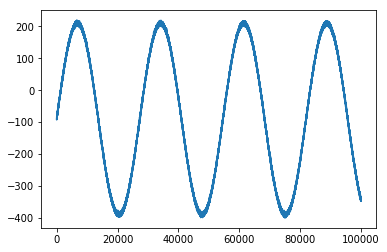

In [33]:
pulses = np.sin(np.arange(n) / (n / 23)) - 0.3
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)
plt.show()

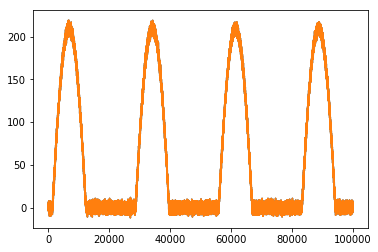

In [35]:
# Hacking up a noisy pulse train
pulses = np.sin(np.arange(n) / (n / 23)) - 0.3
pulses = np.maximum(pulses, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)
plt.show()

Now try filling in body of this ufunc:

In [36]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    ### Replace this implementation with yours
    result = waveform_value
    ###
    return result

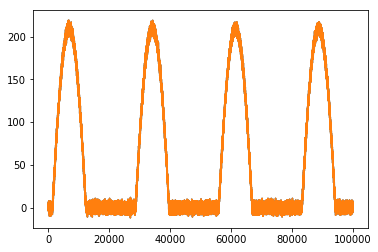

In [38]:
# the noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15.0))
plt.show()

### My Answer

In [39]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    ### Replace this implementation with yours
    result = waveform_value
    
    if (result > threshold):
        return result
    else:
        return 0

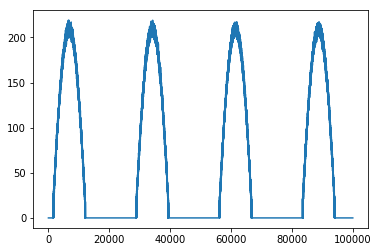

In [40]:
# the noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15.0))
plt.show()

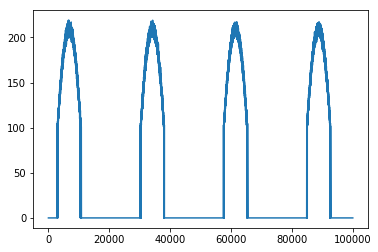

In [42]:
plt.plot(zero_suppress(waveform, 100))
plt.show()